Epoch 0: Loss=2.5046e+01, Phys=2.4969e+01, BC=7.7836e-02


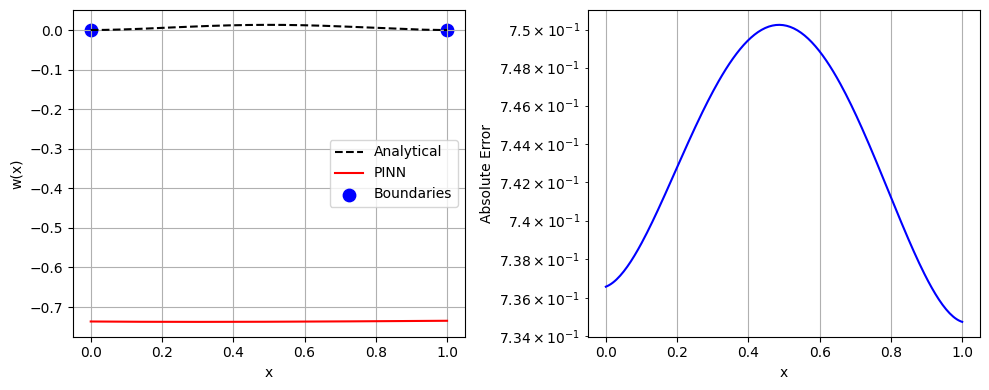

Epoch 1000: Loss=1.8062e-02, Phys=1.5163e-02, BC=2.8988e-03


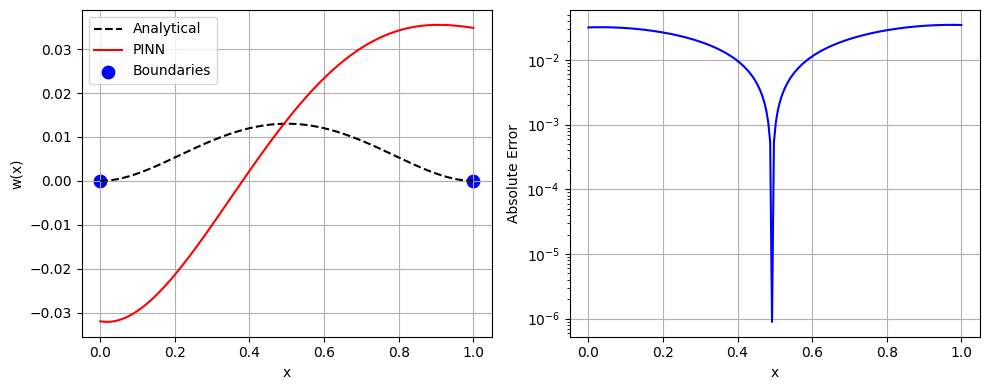

Epoch 2000: Loss=1.8158e-04, Phys=8.5625e-05, BC=9.5953e-05


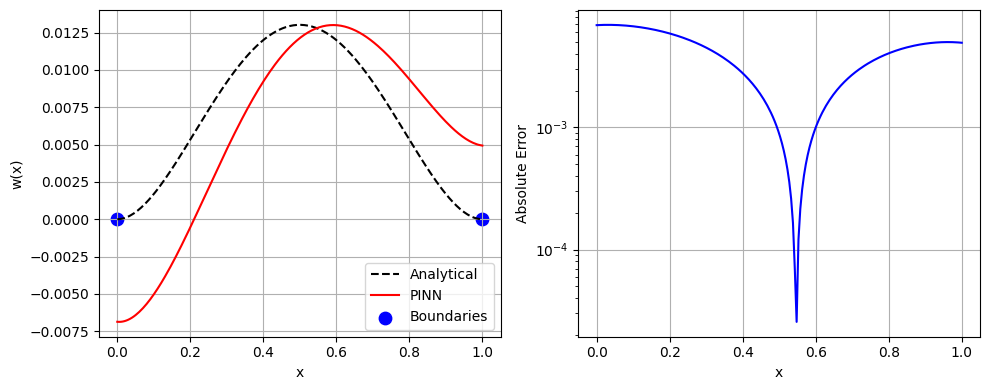

Epoch 3000: Loss=9.6754e-03, Phys=9.5336e-03, BC=1.4182e-04


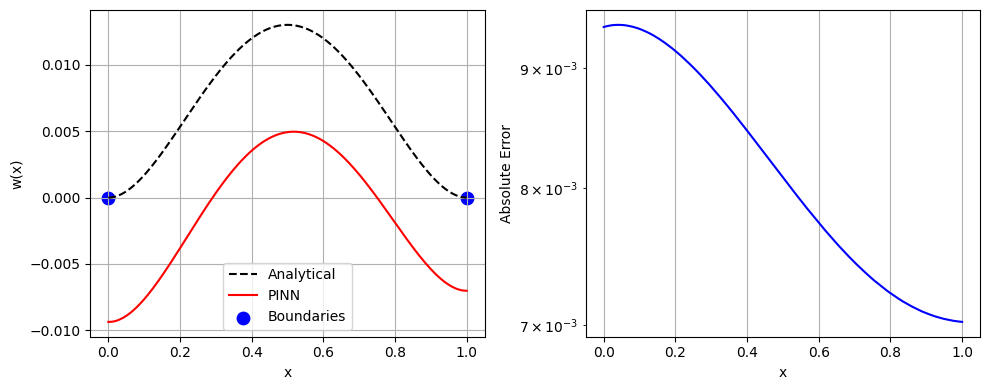

Epoch 4000: Loss=3.3950e-05, Phys=1.6573e-05, BC=1.7377e-05


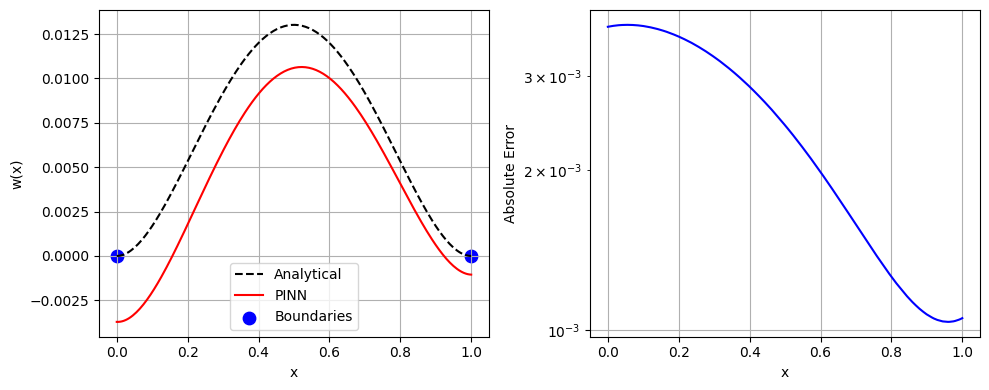

Epoch 5000: Loss=7.4152e-06, Phys=7.4070e-06, BC=8.2723e-09


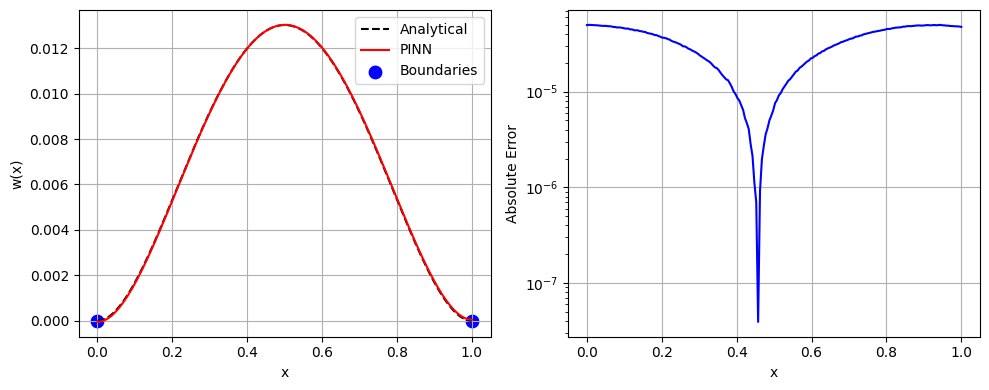

Epoch 6000: Loss=3.6771e-06, Phys=3.6753e-06, BC=1.8213e-09


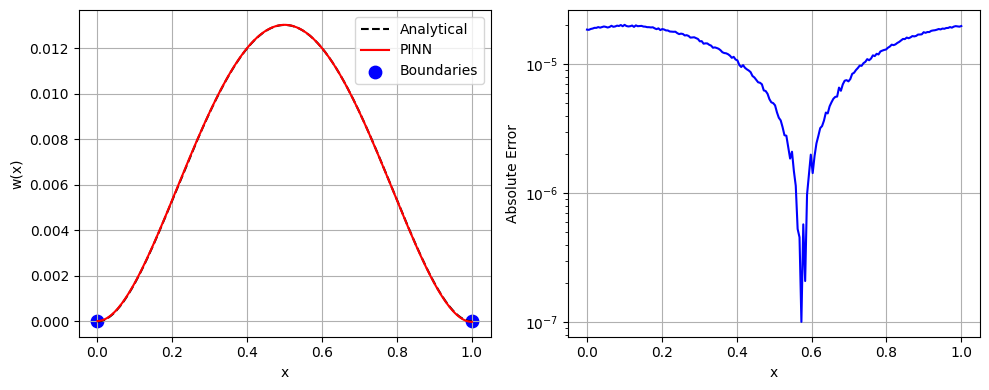

Epoch 7000: Loss=4.1718e-06, Phys=4.1707e-06, BC=1.1572e-09


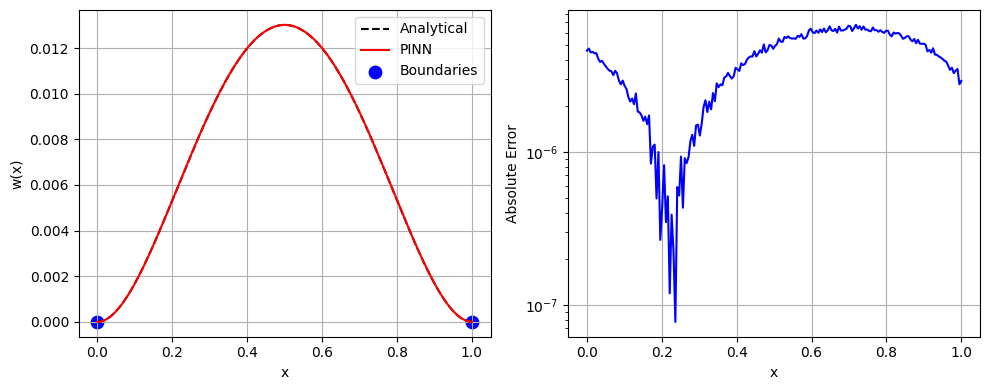

Epoch 8000: Loss=2.7142e-06, Phys=2.7135e-06, BC=7.4061e-10


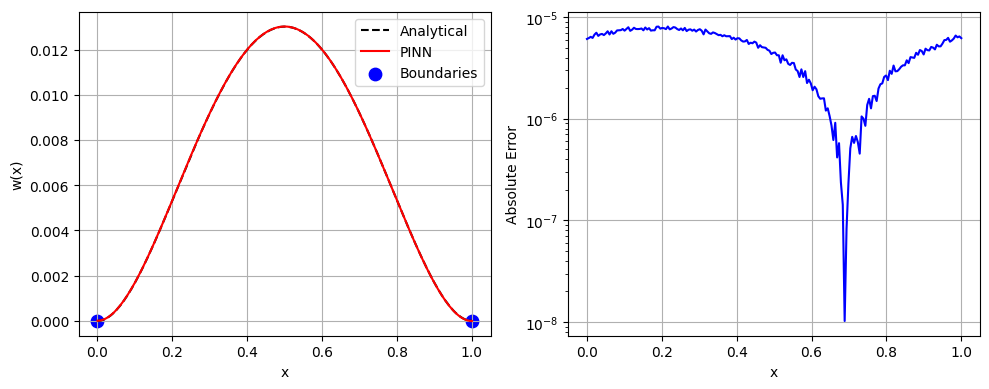

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Настройки задачи
L = 1.0           # Длина балки
EI = 200          # Жесткость
q0 = 1000         # Нагрузка
target_rhs = q0 / EI

# Корректная архитектура
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
        # Инициализация весов
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
    
    def forward(self, x):
        return self.net(x)

# Модель и оптимизатор
pinn = PINN()
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=500, factor=0.5)

# Точки границ
x_left = torch.tensor([[0.0]], requires_grad=True)
x_right = torch.tensor([[L]], requires_grad=True)

# Коллокационные точки (добавляем границы)
x_physics = torch.linspace(0, L, 300).view(-1, 1).requires_grad_(True)

def gradients(y, x, order=1):
    grad = y
    for _ in range(order):
        grad = torch.autograd.grad(
            grad, x, 
            grad_outputs=torch.ones_like(grad),
            create_graph=True,
            retain_graph=True
        )[0]
    return grad

# Обучение
for epoch in range(8001):
    optimiser.zero_grad()
    
    # Физические точки
    w_pred = pinn(x_physics)
    w_x4 = gradients(w_pred, x_physics, 4)
    loss_phys = torch.mean((w_x4 - target_rhs)**2)  # Уравнение: d⁴w/dx⁴ = -q/EI
    
    # Граничные условия (раздельные!)
    w_left = pinn(x_left)
    dw_left = gradients(w_left, x_left, 1)
    
    w_right = pinn(x_right)
    dw_right = gradients(w_right, x_right, 1)
    
    loss_bc = (w_left**2 + dw_left**2 + w_right**2 + dw_right**2)
    
    # Сбалансированные веса
    loss = loss_phys + loss_bc
    
    loss.backward()
    optimiser.step()
    scheduler.step(loss)
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4e}, Phys={loss_phys.item():.4e}, BC={loss_bc.item():.4e}")
        
        # Визуализация
        with torch.no_grad():
            x_test = torch.linspace(0, L, 200).view(-1, 1)
            w_pred = pinn(x_test).numpy()
            
        # Правильное аналитическое решение для защемленной балки
        x_np = x_test.numpy()
        w_exact = (q0/(24*EI)) * (x_np**2) * (L - x_np)**2
        
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.plot(x_np, w_exact, 'k--', label="Analytical")
        plt.plot(x_np, w_pred, 'r-', label="PINN")
        plt.scatter([0, L], [0, 0], c='blue', s=80, label="Boundaries")
        plt.xlabel("x")
        plt.ylabel("w(x)")
        plt.legend()
        plt.grid(True)
        
        plt.subplot(122)
        plt.semilogy()
        plt.plot(x_np, np.abs(w_pred - w_exact), 'b-')
        plt.xlabel("x")
        plt.ylabel("Absolute Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()